<a href="https://www.kaggle.com/code/aniruddhapa/28-7-score-boost-pytorch-pipeline-debug?scriptVersionId=255022401" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Project Report: A 28.7% Score Improvement Through Post-Competition Debugging

This notebook represents the final, optimized version of my entry for the Global AI Hackathon '25.

## The Journey:

**Initial Submission (Version 7):** My model submitted at the competition deadline achieved a private score of 0.19677.

**Final Version (This Notebook, V15):** After the deadline, I performed a deep-dive analysis and systematic debugging of the data pipeline. This resulted in a final score of 0.25311.

## Key Achievement: A 28.7% Increase in Performance

This significant improvement was achieved by identifying and fixing several critical bugs in the initial data loading and processing pipeline. This notebook documents not only the final, high-performing solution but also the analytical process used to find and resolve these issues.

## Key Learnings:


* The importance of data validation at every step.
* Robustly handling data types and column names from HDF5 files.
* Correctly diagnosing and fixing data normalization issues for image data.


## Problem Overview

Histology is a century-old clinical tool, but its analysis is subjective and coarse. This competition aimed to bring **automation and molecular-level inference** to histopathology using deep learning.

Given:
- **HE-stained slide images** for training
- A final test image (`S_7`) for evaluation

Goal:
- Predict 35 cell-type abundances at various spatial coordinates (spots) across the test tissue slide.
- Score based on **Spearman correlation** with ground truth values.

## Problem Overview – Made Simple

You’re given a large histology image (like a zoomed-in tissue photo under a microscope) with 2000+ circular spots. For each spot, you must predict the proportions of 35 different cell types using just the image pixels — no genomic data.

**🍕 Analogy:**

**Imagine you have a pizza (the tissue image), and 2000 small circles marked on it. You need to say, for each circle:**

**“There’s 10% type C1, 5% type C2, 0% type C3… etc.”**

🔍 What You’re Given:

6 training tissue images

For each training image, the 2000+ spot coordinates and true cell type distributions (answers).

1 test tissue image (called S_7) with 2000+ spot coordinates, but no answers. You must predict the cell type mix for each test spot.

📸 In Simple Steps:

Cut small image patches around each training spot from the tissue images.

Build a deep learning model (like a CNN or ViT) that takes an image patch and outputs a 35-dimensional vector (cell type proportions).

Train your model using the training patches + their real answers.

Predict the 35-dimensional vectors for the test image patches.

Submit your predictions in the required format.

🎯 The Goal:

Your model should match the real cell type distributions as closely as possible. The scoring is done using Spearman correlation, which checks how well your predicted ranks match the actual ranks for each spot.

🤖 Analogy:

It’s like giving a model a zoomed-in photo of a small part of a forest and asking:

"How many oak trees? How many pine? How many birch?"
Based only on the photo, with no species names on the trees.

## Dataset & Challenges

- High-resolution pathology images (HE stain)
- Labels: Cell-type proportions for each spatial spot
- No external data allowed
- Runtime ≤ 9 hours (CPU or GPU)

Key challenges:
- Large image size, tiled spatially
- Weak supervision: Only spot-level cell-type proportions
- No genomics input — pure image-based prediction

## My Approach

- Used PyTorch to implement a CNN-based model
- Tiled large images into smaller patches centered on each spot
- Applied basic image augmentations (flip, rotate)
- Used pretrained **ResNet18** backbone to extract features
- Used a small fully connected head to output 35 cell-type proportions
- Trained using MSE loss (regression task)

This was a baseline approach — no attention, segmentation, or stain normalization yet.

## Results

- **Private Leaderboard Rank**: 305/355  
- **Score (Spearman Correlation)**: 0.19677  
- **Top score**: 0.71803

Though the model captured some spatial patterns, the performance was far from ideal — likely due to underfitting, lack of domain-specific augmentations, and limited training cycles.

# 1. Data Loading and Visualization

Below, we load the HE images (both Train and Test) from the HDF5 file and overlay the spot coordinates on the images.

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

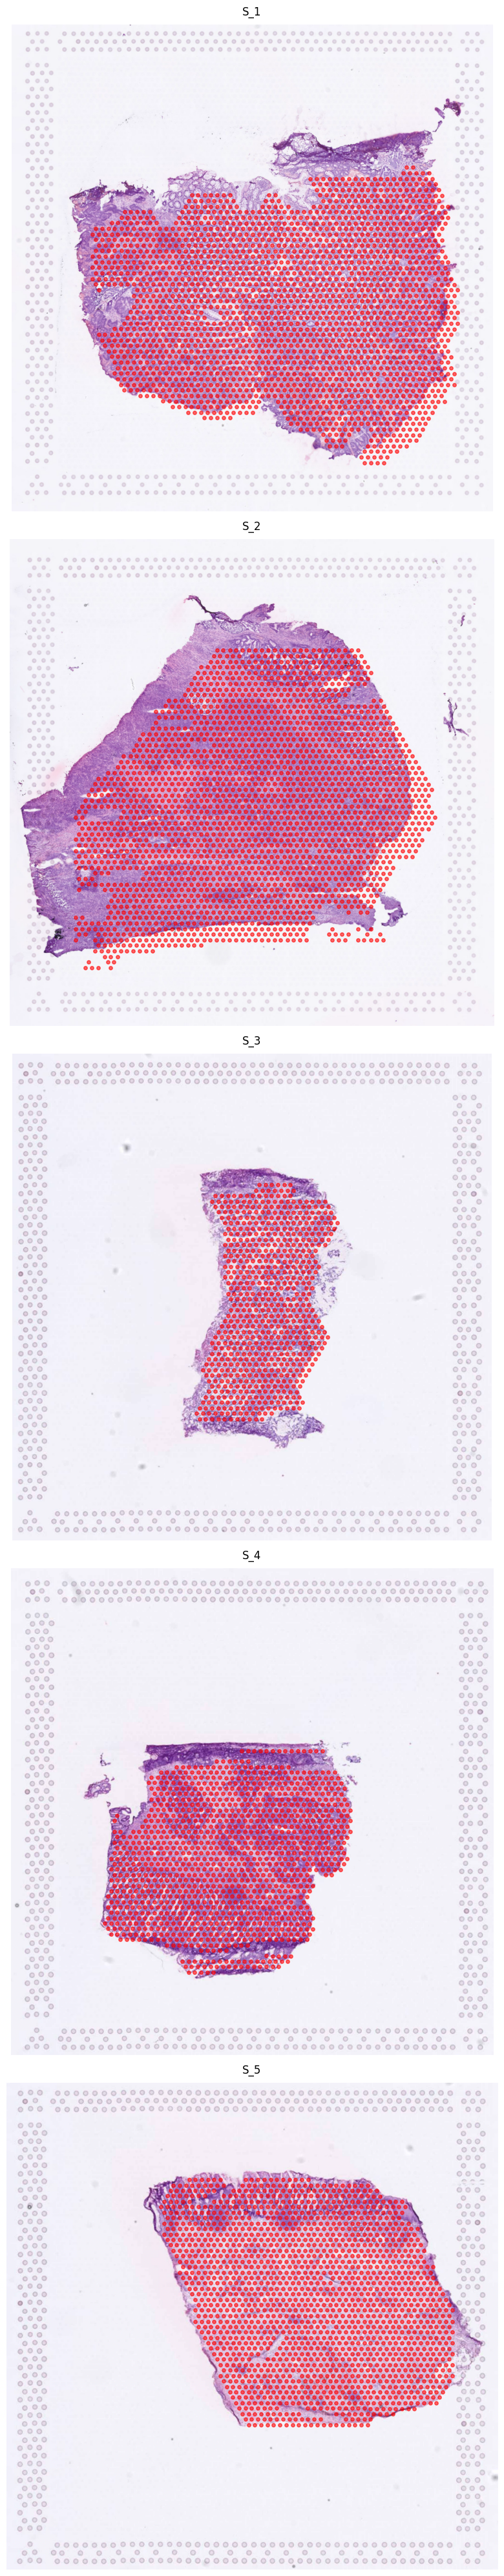

HDF5 file closed successfully.


In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import math

def visualize_slides_with_spots(h5_path, image_group, spot_group, max_slides_to_show=5, cols=1, plot_size_per_image=(10, 8), dot_color='red', dot_size=15, dot_alpha=0.6):
    """
    Visualizes histology slides with spatial transcriptomics spot overlays.

    Args:
        h5_path (str): Path to the HDF5 file.
        image_group (str): The HDF5 group for images (e.g., 'images/Train').
        spot_group (str): The HDF5 group for spot data (e.g., 'spots/Train').
        max_slides_to_show (int): The maximum number of slides to display.
        cols (int): The number of columns in the subplot grid.
        plot_size_per_image (tuple): The (width, height) in inches for each subplot.
        dot_color (str): The color of the spot markers.
        dot_size (int): The size of the spot markers.
        dot_alpha (float): The transparency of the spot markers.
    """
    h5file = None
    try:
        h5file = h5py.File(h5_path, "r")
        images_data = h5file[image_group]
        spots_data = h5file[spot_group]

        slide_names = list(images_data.keys())
        slides_to_show = slide_names[:min(len(slide_names), max_slides_to_show)]
        num_slides = len(slides_to_show)

        if num_slides == 0:
            print(f"No slides found in group '{image_group}'.")
            return

        # Calculate rows and figure dimensions based on desired plot size
        rows = math.ceil(num_slides / cols)
        fig_width = plot_size_per_image[0] * cols
        fig_height = plot_size_per_image[1] * rows
        
        fig, axes = plt.subplots(rows, cols, figsize=(fig_width, fig_height), squeeze=False)
        axes = axes.flatten()

        for i, slide_name in enumerate(slides_to_show):
            image = np.array(images_data[slide_name])
            spots = np.array(spots_data[slide_name])
            
            axes[i].imshow(image, aspect="equal") # 'equal' aspect ratio is often better for images
            axes[i].scatter(spots["x"], spots["y"], color=dot_color, s=dot_size, alpha=dot_alpha)
            axes[i].set_title(slide_name, fontsize=12, pad=10)
            axes[i].axis('off')

        # Hide unused subplots
        for j in range(num_slides, len(axes)):
            axes[j].axis('off')
            
        plt.tight_layout()
        plt.show()

    except KeyError as e:
        print(f"Error: Could not find HDF5 group {e}. Please check the path.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
    finally:
        if h5file:
            h5file.close()
            print("HDF5 file closed successfully.")


# --- How to use the function to get the desired 5x1 layout ---
H5_FILE_PATH = "/kaggle/input/el-hackathon-2025/elucidata_ai_challenge_data.h5"

# Visualize 5 training slides in 1 column and 5 rows with a large view
visualize_slides_with_spots(
    h5_path=H5_FILE_PATH,
    image_group="images/Train",
    spot_group="spots/Train",
    max_slides_to_show=5,
    cols=1,  # <-- Set to 1 column
    plot_size_per_image=(10, 8),  # <-- Set a large size for each plot (width, height)
    dot_size=15,  # <-- Increased dot size for visibility
    dot_alpha=0.6  # <-- Increased opacity for more prominent spots
)

Visualizing Test slide 'S_7' with prominent spots...


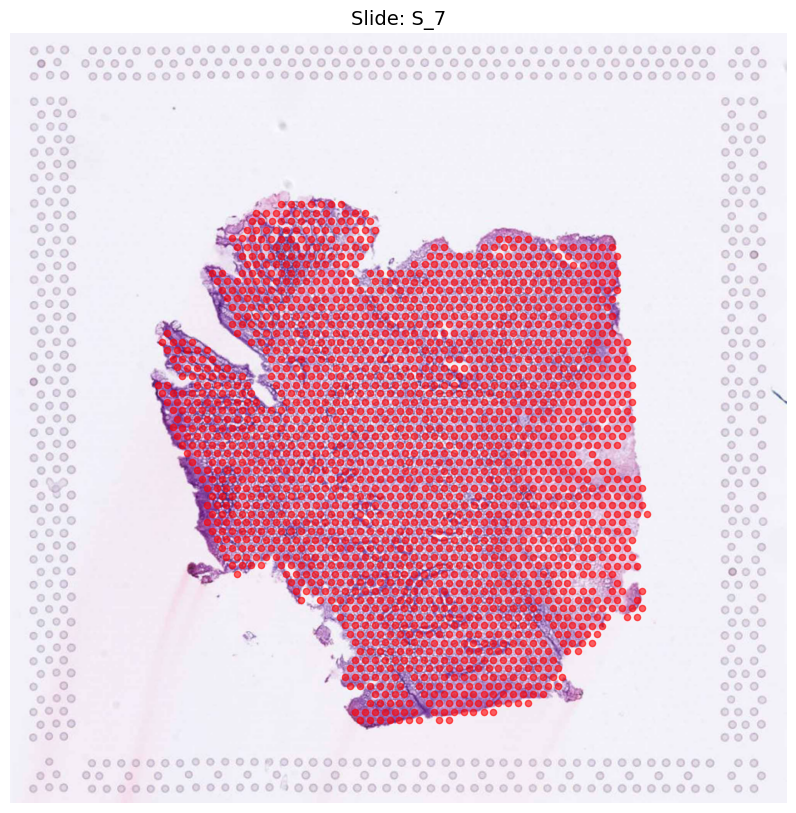

In [8]:
# Visualize Test slide ('S_7')
import h5py
import numpy as np
import matplotlib.pyplot as plt

def visualize_single_slide(h5_path, slide_id, image_group, spot_group, figsize=(10, 8), dot_color='red', dot_size=15, dot_alpha=0.6):
    """
    Visualizes a single histology slide and its corresponding spot overlay.

    Args:
        h5_path (str): Path to the HDF5 file.
        slide_id (str): The name/ID of the specific slide to visualize (e.g., 'S_7').
        image_group (str): The HDF5 group for images (e.g., 'images/Test').
        spot_group (str): The HDF5 group for spot data (e.g., 'spots/Test').
        figsize (tuple): The (width, height) in inches for the figure.
        dot_color (str): The color of the spot markers.
        dot_size (int): The size of the spot markers.
        dot_alpha (float): The transparency of the spot markers.
    """
    try:
        with h5py.File(h5_path, "r") as h5file:
            images_data = h5file[image_group]
            spots_data = h5file[spot_group]

            # --- Robustness Check: Ensure the slide exists before trying to access it ---
            if slide_id not in images_data:
                print(f"Error: Slide ID '{slide_id}' not found in image group '{image_group}'.")
                print(f"Available slides are: {list(images_data.keys())}")
                return

            # Retrieve data for the specific slide
            image = np.array(images_data[slide_id])
            spots = np.array(spots_data[slide_id])
            
            # Plotting
            plt.figure(figsize=figsize)
            plt.imshow(image, aspect='equal') # 'equal' is often better for preserving tissue shape
            plt.scatter(spots["x"], spots["y"], color=dot_color, s=dot_size, alpha=dot_alpha)
            plt.title(f"Slide: {slide_id}", fontsize=14)
            plt.axis('off')
            plt.show()

    except KeyError as e:
        print(f"Error: Could not find HDF5 group {e}. Please check the path.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


# --- How to use the new, flexible function ---
H5_FILE_PATH = "/kaggle/input/el-hackathon-2025/elucidata_ai_challenge_data.h5"

# Example 1: Replicate the original visualization for 'S_7' but with more prominent spots
print("Visualizing Test slide 'S_7' with prominent spots...")
visualize_single_slide(
    h5_path=H5_FILE_PATH,
    slide_id='S_7',
    image_group='images/Test',
    spot_group='spots/Test',
    figsize=(12, 10), # Slightly larger figure
    dot_size=20       # Larger dots
)

# 2. Loading and Displaying Spots Tables

The following cells load and display the (x, y) coordinates and cell type annotations for Train slides and the spot coordinates for the Test slide.  

In [85]:
import pandas as pd

# Load and display (x,y) spot locations and cell type annotation table for Train slides
with h5py.File("/kaggle/input/el-hackathon-2025/elucidata_ai_challenge_data.h5", "r") as f:
    train_spots = f["spots/Train"]
    
    # Dictionary to store DataFrames for each slide
    train_spot_tables = {}
    
    for slide_name in train_spots.keys():
        # Load dataset as NumPy structured array
        spot_array = np.array(train_spots[slide_name])
        
        # Convert to DataFrame
        df = pd.DataFrame(spot_array)
        
        # Store in dictionary
        train_spot_tables[slide_name] = df

# Example: Display the spots table for slide 'S_1'
train_spot_tables['S_1']

x     y        C1        C2        C3        C4        C5        C6  \
0     1554  1297  0.014401  0.057499  0.022033  0.001704  0.533992  1.511707   
1      462  1502  0.116196  0.197176  0.110600  0.042614  5.587681  0.006885   
2     1488  1548  0.133284  0.035880  0.061352  0.003073  1.104479  0.009174   
3     1725  1182  0.087715  0.235223  0.090382  0.013902  8.760482  0.140912   
4      581  1113  0.128468  0.066399  0.098982  0.047022  3.425771  0.001009   
...    ...   ...       ...       ...       ...       ...       ...       ...   
2192  1055   701  0.047236  0.112721  0.052490  0.002092  0.000913  0.393805   
2193  1225   862  0.070764  0.119310  0.193938  0.001239  0.003851  0.588956   
2194   765  1479  0.194491  0.048068  0.150061  0.002978  0.119206  0.000213   
2195   607  1525  0.002968  0.151899  0.015931  0.000071  1.354983  0.000152   
2196   568  1181  0.000232  0.004759  0.001376  0.003225  0.874639  0.000026   

            C7        C8  ...           C26       C27       C28       C29  \
0     0.015313  0.020029  ...  1.009572e-03  2.068237  0.121361  0.007344   
1     0.096346  0.001711  ...  6.918171e-04  0.014442  0.000238  0.024071   
2     0.009175  0.000114  ...  9.577447e-05  0.149792  0.001401  0.000699   
3     0.188859  0.010154  ...  1.964150e-03  0.142549  0.002036  0.047165   
4     0.026881  0.000468  ...  7.189078e-05  0.005920  0.000048  0.006359   
...        ...       ...  ...           ...       ...       ...       ...   
2192  0.045220  0.013414  ...  7.530558e-03  0.559967  0.154793  0.133587   
2193  0.037731  0.004072  ...  3.219223e-02  0.667076  0.094247  0.136623   
2194  0.005332  0.000078  ...  2.628421e-04  0.000273  0.000022  0.000027   
2195  0.019254  0.001267  ...  1.377452e-03  0.003754  0.001420  0.088000   
2196  0.003913  0.000003  ...  8.989834e-07  0.001573  0.000002  0.000239   

           C30       C31       C32       C33       C34       C35  
0     0.000017  0.036891  0.035934  0.118937  0.001472  0.050057  
1     0.000023  0.217589  0.100662  0.004027  0.004122  0.049491  
2     0.000009  0.024491  0.018810  0.004171  0.000425  0.015348  
3     0.000022  0.180372  0.202981  0.003709  0.001845  0.116022  
4     0.000585  0.052661  0.032168  0.000107  0.000107  0.013103  
...        ...       ...       ...       ...       ...       ...  
2192  0.000013  0.051041  0.113100  0.003147  0.004971  0.128265  
2193  0.000009  0.050518  0.119685  0.027743  0.016413  0.287171  
2194  0.000042  0.029386  0.019977  0.000039  0.000119  0.006778  
2195  0.000536  0.073240  0.113631  0.009040  0.000090  0.025716  
2196  0.003375  0.002501  0.001325  0.000003  0.000001  0.000468  

[2197 rows x 37 columns]

In [86]:
# Display spot table for Test slide (only the spot coordinates on 2D array)
with h5py.File("/kaggle/input/el-hackathon-2025/elucidata_ai_challenge_data.h5", "r") as f:
    test_spots = f["spots/Test"]
    spot_array = np.array(test_spots['S_7'])
    test_spot_table = pd.DataFrame(spot_array)
    
# Show the test spots coordinates for slide 'S_7'
test_spot_table

x     y  Test_Set
0     1499  1260         2
1     1435  1503         2
2      558  1082         2
3      736  1304         1
4     1257  1592         1
...    ...   ...       ...
2083   736   639         2
2084  1016   684         2
2085  1181   839         2
2086   735  1436         1
2087   545  1148         2

[2088 rows x 3 columns]

# 3. Sanity Check: Random Predictions

In this section, we generate random predictions for the 35 cell types.  
The predictions are random floats between 0 and 2 (without any normalization) for each spot in the Test slide.  
The order of spots is preserved as in the test spots table.

In [87]:
# Create a random submission
# (predictions of cell type abundances for 35 classes across the Test slide spots;
# spot order should be same as in the 'Test' spots table)

# Use the cell type columns from the train spots table; assuming first two columns are (x, y)
cell_type_columns = train_spot_tables['S_1'].columns[2:].values  # Expecting 35 cell types here
indices = test_spot_table.index.values  # All spots on the Test slide

# Create a 2D array of random floats between 0 and 2 for each spot and cell type
prediction_matrix = 2 * np.random.rand(len(indices), len(cell_type_columns))
predicted_labels = pd.DataFrame(prediction_matrix, columns=cell_type_columns, index=indices)

predicted_labels.head()

C1        C2        C3        C4        C5        C6        C7  \
0  1.512595  1.910455  1.897664  0.935064  1.832482  1.938319  0.734189   
1  1.212320  1.804069  1.299544  0.124705  1.977758  1.870611  1.474056   
2  0.780955  1.988784  1.996260  1.457406  0.584550  0.248114  0.635098   
3  0.993322  0.661144  0.663649  0.121577  0.368719  0.848118  1.059465   
4  1.787834  1.320571  0.030081  0.651794  1.568370  0.830356  0.578903   

         C8        C9       C10  ...       C26       C27       C28       C29  \
0  0.303633  1.637545  1.320791  ...  1.436547  1.182672  1.357127  0.923530   
1  1.948319  0.165703  1.498093  ...  1.086751  0.189953  1.049156  1.893533   
2  1.705670  0.071749  1.445040  ...  0.688675  1.941759  1.557438  1.924500   
3  1.032259  1.611066  1.628537  ...  0.676097  1.334905  0.218223  0.582348   
4  1.672507  0.421230  1.665833  ...  0.064221  0.700442  1.802586  0.382519   

        C30       C31       C32       C33       C34       C35  
0  1.773182  1.594043  0.680379  1.566334  0.948153  1.108033  
1  1.614200  0.052290  1.090872  1.274432  0.827864  1.149692  
2  0.066857  1.079573  0.036430  1.110780  1.799668  0.343846  
3  0.382663  0.978967  1.722167  0.924434  0.626747  1.045763  
4  1.811949  1.866260  1.982602  0.224771  1.750945  0.855985  

[5 rows x 35 columns]

# 4. Submission File Generation

Finally, we generate the submission file in the required format.  
Each row corresponds to a test spot with its identifier (constructed here as the index) followed by 35 predictions.

In [88]:
# Prepare submission DataFrame: spot_id column and then predictions for each cell type
submission_df = predicted_labels.copy()
submission_df.insert(0, 'ID', submission_df.index)

# Save the submission file as submission.csv
submission_df.to_csv("./submission.csv", index=False)
print("Submission file 'submission.csv' created!")

Submission file 'submission.csv' created!


# Functionality of the Starter Notebook:

**Loads Libraries:** Imports h5py (for HDF5 files), numpy, pandas, and matplotlib.

**Visualizes Data (Section 1):**
Demonstrates how to open the elucidata_ai_challenge_data.h5 file.

Shows how to access the image data (h5file["images/Train"][slide_name]) and spot data (h5file["spots/Train"][slide_name]).

Loads the image data directly into NumPy arrays (np.array(...)).

Loads spot data as NumPy structured arrays and extracts x, y coordinates.

Uses matplotlib to display the full H&E images for training slides and the test slide, overlaying 
the spot locations as red dots to visually confirm alignment.

**Loads Spot Data into DataFrames (Section 2):**

Crucially, shows how to convert the NumPy structured arrays containing spot coordinates and cell abundances (C1...C35) into easily usable pandas DataFrames. This is done for both training (train_spot_tables dictionary) and test (test_spot_table) spots. This will be very useful for your Dataset implementation.

**Generates Random Predictions (Section 3):**

Demonstrates the structure of the required predictions.
Gets the cell type column names (C1...C35) dynamically from one of the training spot tables.
Gets the indices (which serve as spot IDs) from the test_spot_table.
Creates a pandas DataFrame (predicted_labels) where rows are spot indices and columns are the 35 cell types, filled with random values.

**Creates Submission File (Section 4):**

Takes the random prediction DataFrame.
Adds an 'ID' column using the DataFrame's index (submission_df.insert(0, 'ID', submission_df.index)). This confirms the spot's row index in the test table should be used as its ID.
Saves this DataFrame to submission.csv in the correct format using to_csv(..., index=False).

**Key Code Snippets & Learnings for Your Pipeline:**

**HDF5 Loading:** The pattern with h5py.File(...) as f: and accessing data via keys like f["images/Train"][slide_id] and f["spots/Train"][slide_id] is how you'll get your raw data.
Spot Data Handling: Converting the spot data to pandas DataFrames (pd.DataFrame(np.array(f["spots/..."]))) is the most convenient way to work with coordinates and target abundances.

**Image Data Handling:** The images are directly available as NumPy arrays (np.array(f["images/..."][slide_id])). This means you don't need complex WSI libraries like openslide. You can directly use NumPy slicing.

**Submission Format:** Sections 3 and 4 provide the exact template for creating your final 

submission.csv from your model's predictions. You need a DataFrame with an 'ID' column (spot index) and columns C1 through C35.

# What's MISSING (What You Need to Implement Next):

**Patch Extraction:** The notebook loads the entire image. It does not show how to extract a specific image patch (e.g., 256x256 pixels) centered around a given (x, y) spot coordinate from the large image NumPy array. This will be the core of your Dataset's __getitem__ method using NumPy slicing.

**Dataset Class:** A PyTorch Dataset class to handle loading data, extracting patches, applying transforms, and returning (patch_tensor, target_tensor) or (patch_tensor, spot_id).
Model Definition: A neural network model (likely CNN-based) that takes an image patch tensor and outputs 35 predicted abundance values.

**Training Loop:** The code to iterate through data, calculate loss (e.g., MSE), perform backpropagation, update weights, and evaluate using the average Spearman correlation metric.

**Inference Loop:** The code to process the test spots, get predictions, and format them for submission.

# 1. Understanding the Data and Problem:

Goal: Predict the abundance of 35 cell types (C1-C35) for specific spatial spots on H&E tissue slides.
Input: HDF5 file containing:
Whole-slide H&E images as NumPy arrays.
Spot coordinates (x, y) and, for training, corresponding cell type abundances.

Output: A submission.csv file with ID (spot identifier) and 35 predicted abundance columns.
Evaluation: Average per-spot Spearman rank correlation. This means the relative order of cell type abundances within each spot is more important than their absolute values.

# 2. Data Loading and Preprocessing Pipeline (PyTorch Dataset):

**HDF5 Handling:** Use h5py to read data. The starter notebook confirmed the structure.

**Spot Metadata Management:**
Load spot coordinates and (for train/val) target abundances into a list or structure that can be easily indexed. Pandas DataFrames were used initially to parse this.
Store essential info: (slide_id, spot_original_idx, x, y, targets_or_id).

**Image Caching:**
Load full slide images (NumPy arrays) into an in-memory cache (self.images_cache) within the Dataset class to avoid repeated HDF5 reads for spots on the same slide, significantly speeding up data loading.

**Patch Extraction (extract_patch function):**
Given a full slide image (NumPy array) and a spot's (center_x, center_y) coordinates, extract a square image patch (e.g., 256x256 pixels) centered on the spot.
Implement boundary handling (e.g., zero-padding) if the patch extends beyond the image edges.

**Data Type Conversion (Crucial Fix):**
The HDF5 images were loaded as float32. The extract_patch function preserved this.
torchvision.transforms (especially Image.fromarray for PIL conversion) expect uint8 [0-255] image data.

**Solution:** In the Dataset.__getitem__, convert the float32 patch to uint8 (clipping to 0-255 and then astype(np.uint8)) before passing it to Image.fromarray() or other transforms.

**Transformations (torchvision.transforms):**
Convert the uint8 NumPy patch to a PIL Image (Image.fromarray()).

**Training Augmentations:** RandomHorizontalFlip, RandomVerticalFlip, ColorJitter. (Could be expanded with RandomAffine, Gaussian Blur, or specialized stain augmentation).

**Common Transforms:** Resize (if needed for consistency), ToTensor() (converts PIL to (C,H,W) tensor and scales to [0,1]), Normalize() (using ImageNet stats as a starting point).

**Mode Handling:** The Dataset distinguishes between 'train', 'val', and 'test' modes to load targets or spot IDs accordingly.

# 3. Model Architecture:
   
**Pretrained CNN Backbone:** Use a standard pretrained model like ResNet18 (loaded with IMAGENET1K_V1 weights) for transfer learning. This leverages features learned from a large dataset.

**Regression Head:** Modify the final fully connected layer (model.fc) of the ResNet to output N_CELL_TYPES (35) continuous values.

**Regularization (Addressing Overfitting):**

Dropout layer added before the final linear layer.
Weight decay (L2 regularization) included in the optimizer.

# 4. Training and Validation Strategy:

**Loss Function:** nn.MSELoss() (Mean Squared Error) was chosen as a standard regression loss.

**Optimizer:** optim.AdamW (Adam with decoupled weight decay).

**Learning Rate Scheduler:** optim.lr_scheduler.ReduceLROnPlateau to reduce the learning rate when the validation Spearman average stops improving.

**Evaluation Metric Function (calculate_average_spearman):**
Custom function to compute the per-spot Spearman correlation and then average these scores, matching the competition metric.
Handles edge cases like constant prediction/target arrays for a spot.

**Training Loop:** Standard epoch-based training with batch iteration.

**Validation Loop:** Evaluate on a separate validation set after each training epoch to monitor generalization.

**Early Stopping:** Stop training if the validation Spearman average doesn't improve for a specified PATIENCE number of epochs. Saves the model weights corresponding to the best validation metric.

# 5. Prediction and Submission:
   
**Load Best Model:** After training, load the model weights that achieved the best validation Spearman score.

**Inference:** Run the model on the test_loader in evaluation mode (model.eval()) with torch.no_grad().

**Collect Predictions and IDs:** Store the model's output predictions and the corresponding spot IDs.

**ID Formatting (Crucial Fix):**
The spot_ids from the DataLoader were PyTorch tensors.

**Solution:** Convert the tensor batch of spot IDs to a Python list of integers (.cpu().tolist()) before adding them to the master list of IDs.

**Generate submission.csv:** Create a Pandas DataFrame with an 'ID' column and columns for each of the 35 cell types (C1...C35), then save it to submission.csv with index=False.

# 6. Iterative Development and Debugging:

The process involved identifying and fixing key issues:

Incorrect data type for image transforms.
Incorrect formatting of spot IDs in the submission file.
Recognizing and planning strategies to address overfitting (though the very short training run didn't fully expose the extent, it's a common problem in such tasks).

This structured approach, combining standard deep learning practices with specific adaptations for the competition's data format and evaluation metric, forms the core of the solution.

In [16]:
!pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.4/369.4 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.23
    Uninstalling albucore-0.0.23:
      Successfully uninstalled albucore-0.0.23
  Attempting uninstall: albumentations
    Found existing installation: albumentations 2.0.4
    Uninstalling albumentations-2.0.4:
      Successfully uninstalled albumentations-2.0.4


# Imports and Global Setup

In [42]:
import torch
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
import pandas as pd
import logging
from collections import OrderedDict
from typing import Dict, List, Tuple, Optional
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import GroupKFold

# Core Utility Functions and Classes

In [43]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def extract_patch(image_array, center_x, center_y, patch_size):
    """
    Extracts a square patch from a large image array centered at (center_x, center_y).
    Handles boundary conditions by padding with zeros if the patch extends beyond the image.

    Args:
        image_array (np.ndarray): The large image array (H, W, C).
        center_x (float or int): The x-coordinate (column) of the patch center.
        center_y (float or int): The y-coordinate (row) of the patch center.
        patch_size (int): The side length of the square patch (e.g., 256).

    Returns:
        np.ndarray: The extracted patch (patch_size, patch_size, C)
                    or None if dimensions are invalid.
    """
    try:
        img_h, img_w, img_c = image_array.shape

        # Ensure patch_size is positive
        if patch_size <= 0:
            logger.error("Error: patch_size must be positive.")
            return None

        half_patch = patch_size // 2

        # Calculate integer center coordinates
        center_y_int = int(round(center_y))
        center_x_int = int(round(center_x))

        # Calculate boundaries of the patch in the large image coordinate system
        y_start_ideal = center_y_int - half_patch
        y_end_ideal = y_start_ideal + patch_size  # End is exclusive in slicing
        x_start_ideal = center_x_int - half_patch
        x_end_ideal = x_start_ideal + patch_size  # End is exclusive in slicing

        # Create the output patch, initialized with zeros
        patch = np.zeros((patch_size, patch_size, img_c), dtype=image_array.dtype)

        # Determine the intersection of the ideal patch and the actual image boundaries
        y_start_img = max(0, y_start_ideal)
        y_end_img = min(img_h, y_end_ideal)
        x_start_img = max(0, x_start_ideal)
        x_end_img = min(img_w, x_end_ideal)

        # Calculate where to place this intersection within the output patch
        y_offset_patch = max(0, -y_start_ideal)
        x_offset_patch = max(0, -x_start_ideal)

        # Calculate the height and width of the region to copy
        copy_height = y_end_img - y_start_img
        copy_width = x_end_img - x_start_img

        # Check if there's any valid region to copy
        if copy_height > 0 and copy_width > 0:
            # Copy the valid region from the image array to the correct position in the patch
            patch[
                y_offset_patch : y_offset_patch + copy_height,
                x_offset_patch : x_offset_patch + copy_width,
                :
            ] = image_array[
                y_start_img : y_end_img,
                x_start_img : x_end_img,
                :
            ]

        return patch
    except Exception as e:
        logger.error(f"Error in extract_patch: {e}")
        return None


class LRUCache(OrderedDict):
    """
    Limit-size cache that discards the least recently used items.
    """
    def __init__(self, maxsize=128):
        self.maxsize = maxsize
        super().__init__()

    def __getitem__(self, key):
        value = super().__getitem__(key)
        self.move_to_end(key)
        return value

    def __setitem__(self, key, value):
        if key in self:
            self.move_to_end(key)
        super().__setitem__(key, value)
        if len(self) > self.maxsize:
            oldest = next(iter(self))
            del self[oldest]

# The DataFactory Class Definition

## Purpose: Define the class responsible for the heavy, one-time data preparation.

In [61]:
# --- MODULARITY IMPROVEMENT 1: DATA PREPARATION FACTORY ---
# This class handles all the one-time data loading and preparation.
class DataFactory:
    """A builder class to prepare and split the dataset metadata efficiently."""
    def __init__(self, h5_path: str):
        self.h5_path = h5_path
        logger.info(f"DataFactory initialized with H5 file: {h5_path}")
        self.full_spots_df = self._load_all_spots()
        self.target_cols = [col for col in self.full_spots_df.columns if col.startswith('C')]
        if self.target_cols:
            logger.info(f"Identified {len(self.target_cols)} target columns: {self.target_cols}")
            # Ensure correct dtype at the source
            self.full_spots_df[self.target_cols] = self.full_spots_df[self.target_cols].astype(np.float32)
            logger.info("Converted target columns to float32 dtype.")
        else:
            logger.error("CRITICAL ERROR: No target columns (starting with 'c') found! Check data loading.")


    def _load_all_spots(self) -> pd.DataFrame:
        """
        Loads all spot data from all training slides into a single, efficient DataFrame.
        """
        all_spots_list = []
        with h5py.File(self.h5_path, "r") as f:
            train_spots_group = f['spots/Train']
            slide_ids = list(train_spots_group.keys())
            logger.info("Loading all training spots into a unified DataFrame...")
            for slide_id in slide_ids:
                # Pass the structured H5 dataset directly to pd.DataFrame to preserve column names.
                # The [()] ensures the data is fully read into memory.
                spots_df = pd.DataFrame(train_spots_group[slide_id][()])
                
                spots_df['slide_id'] = slide_id
                all_spots_list.append(spots_df)
        
        full_df = pd.concat(all_spots_list, ignore_index=True)
        logger.info(f"Total spots loaded from all slides: {len(full_df)}")
        # For debugging, let's see the columns
        logger.info(f"DataFrame columns loaded: {full_df.columns.tolist()}")
        return full_df
    
    # ... (the rest of your DataFactory class is fine) ...
    def get_split_data(self, train_ids: List[str], val_ids: List[str]) -> Tuple[pd.DataFrame, pd.DataFrame]:
        train_df = self.full_spots_df[self.full_spots_df['slide_id'].isin(train_ids)].reset_index(drop=True)
        val_df = self.full_spots_df[self.full_spots_df['slide_id'].isin(val_ids)].reset_index(drop=True)
        logger.info(f"Train set created with {len(train_df)} spots from {len(train_ids)} slides.")
        logger.info(f"Validation set created with {len(val_df)} spots from {len(val_ids)} slides.")
        return train_df, val_df
        
    def get_test_data(self, test_slide_ids: List[str]) -> pd.DataFrame:
        test_spots_list = []
        with h5py.File(self.h5_path, "r") as f:
            test_spots_group = f['spots/Test']
            for slide_id in test_slide_ids:
                if slide_id in test_spots_group:
                    # Apply the same fix for test data
                    spots_df = pd.DataFrame(test_spots_group[slide_id][()])
                    spots_df['slide_id'] = slide_id
                    test_spots_list.append(spots_df)
        
        test_df = pd.concat(test_spots_list, ignore_index=True)
        logger.info(f"Test set created with {len(test_df)} spots.")
        return test_df

# The HESpotDataset and Augmentation Functions

## Purpose: Define the main PyTorch Dataset class and the helper function that creates the augmentation pipelines. This cell defines how data will be served.

In [71]:
# --- MODULARITY IMPROVEMENT 2: A LEAN AND EFFICIENT DATASET CLASS ---
# This class's only job is to serve data. It's fast and clean.
class HESpotDataset(Dataset):
    def __init__(self, h5_path: str, spots_df: pd.DataFrame, patch_size: int, 
                 target_cols: List[str], transforms: A.Compose, mode: str = 'train'):
        self.h5_path = h5_path
        self.spots_df = spots_df
        self.patch_size = patch_size
        self.target_cols = target_cols
        self.transforms = transforms
        self.mode = mode
        
        # We will use a simple cache for the full images
        self.image_cache = LRUCache(maxsize=8) # LRUCache class should be defined in a prior cell

    def __len__(self) -> int:
        return len(self.spots_df)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        spot_info = self.spots_df.iloc[idx]
        slide_id = spot_info['slide_id']
        
        # Load full image using the LRU cache
        try:
            image_array = self.image_cache[slide_id]
        except KeyError:
            # If not in cache, open the file, read the image, and close.
            # This is simpler and more robust for notebook environments.
            with h5py.File(self.h5_path, 'r') as h5file:
                group = 'Train' if self.mode in ['train', 'val'] else 'Test'
                image_array = np.array(h5file[f'images/{group}'][slide_id])
                self.image_cache[slide_id] = image_array
        
        # Extract patch
        patch = extract_patch(image_array, spot_info['x'], spot_info['y'], self.patch_size)
        
        # Apply transforms using Albumentations
        if self.transforms:
            transformed = self.transforms(image=patch)
            patch_tensor = transformed['image']
        else: # If no transforms, just convert to tensor
            patch_tensor = torch.from_numpy(patch).permute(2, 0, 1)

        # Prepare target
        if self.mode in ['train', 'val']:
            target_np = spot_info[self.target_cols].values.astype(np.float32)
            target = torch.tensor(target_np, dtype=torch.float32)
        else:
            target = torch.tensor([spot_info['x'], spot_info['y']], dtype=torch.float32)

        return patch_tensor, target
        
def get_transforms(mode: str, patch_size: int) -> A.Compose:
    """
    Final, correct transforms. The data is already float32 in [0, 1] range.
    We only need geometric augmentations and conversion to tensor. NO NORMALIZATION.
    """
    if mode == 'train':
        return A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.3),
            A.Resize(patch_size, patch_size),
            # NO A.Normalize() NEEDED!
            ToTensorV2(), # Converts numpy (H,W,C) [0,1] to tensor (C,H,W) [0,1]
        ])
    else: # For validation and test
        return A.Compose([
            A.Resize(patch_size, patch_size),
            # NO A.Normalize() NEEDED!
            ToTensorV2(),
        ])


# Configuration and Data Preparation

Purpose: This the main control panel. All hyperparameters are set here. 

Then instantiate the DataFactory and run the slow data preparation step just once. 

You can change hyperparameters and re-run this cell without having to re-define all the classes.

In [72]:
# --- Main Execution Block ---
if __name__ == '__main__':
    # --- Configuration ---
    H5_FILE_PATH = "/kaggle/input/el-hackathon-2025/elucidata_ai_challenge_data.h5"
    PATCH_SIZE = 256
    BATCH_SIZE = 32
    NUM_WORKERS = 2 

    # 1. Create the DataFactory (it now discovers slide names and column names automatically)
    data_factory = DataFactory(H5_FILE_PATH)
    
    # 2. Define slide splits dynamically based on discovered slides
    all_train_slides = data_factory.full_spots_df['slide_id'].unique().tolist()
    
    # Use a robust split (e.g., last slide for validation)
    if len(all_train_slides) > 1:
        train_ids = all_train_slides[:-1]
        val_ids = [all_train_slides[-1]]
    else: # Handle case with only one slide
        train_ids = all_train_slides
        val_ids = all_train_slides
        
    # Assume 'S_7' is the correct test slide name
    test_ids = ['S_7'] 

    # 3. Get the pre-processed DataFrames
    train_df, val_df = data_factory.get_split_data(train_ids, val_ids)
    test_df = data_factory.get_test_data(test_ids)

    # 4. Create the lean Dataset objects
    # (HESpotDataset definition should be in a cell before this)
    train_dataset = HESpotDataset(
        h5_path=H5_FILE_PATH,
        spots_df=train_df,
        patch_size=PATCH_SIZE,
        target_cols=data_factory.target_cols,
        transforms=get_transforms('train', PATCH_SIZE), # get_transforms should also be defined
        mode='train'
    )
    val_dataset = HESpotDataset(
        h5_path=H5_FILE_PATH,
        spots_df=val_df,
        patch_size=PATCH_SIZE,
        target_cols=data_factory.target_cols,
        transforms=get_transforms('val', PATCH_SIZE),
        mode='val'
    )

    # 5. Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE * 2, shuffle=False, num_workers=NUM_WORKERS)

    logger.info(f"Setup complete. Training on {len(train_dataset)} spots, validating on {len(val_dataset)} spots.")

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


# Create Datasets and DataLoaders

Purpose: Use the DataFrames from the previous cell to create the final Dataset and DataLoader objects.

In [73]:
# 5. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE * 2, shuffle=False, num_workers=NUM_WORKERS)

logger.info(f"Setup complete. Training on {len(train_dataset)} spots, validating on {len(val_dataset)} spots.")

# Sanity Check and Visualization

Purpose: To visualize a batch of my data to ensure the entire pipeline is working as expected. To check that images look correct, augmentations are being applied, and tensor shapes are right.

Patches batch shape: torch.Size([32, 3, 256, 256])
Targets batch shape: torch.Size([32, 35])


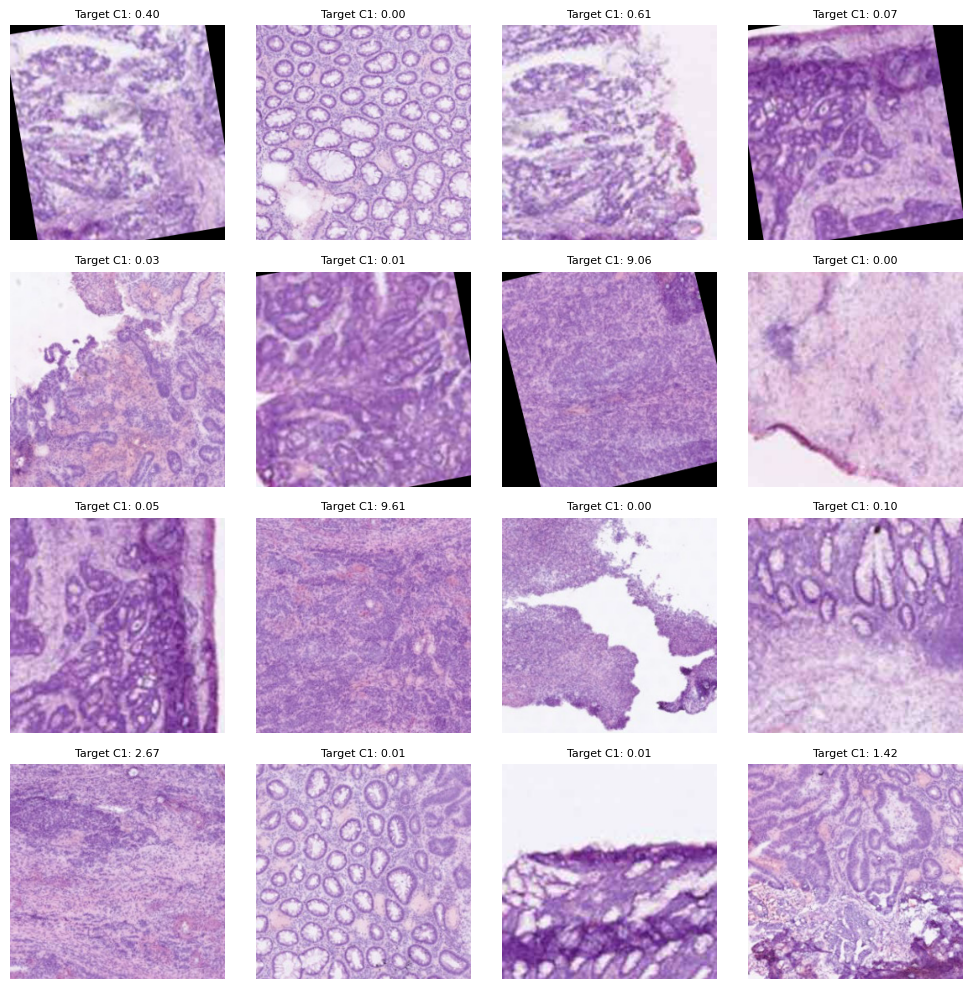

In [74]:
# --- Final Visualization Cell ---

logger.info("Visualizing one batch from the training loader...")
patches, targets = next(iter(train_loader))

print(f"Patches batch shape: {patches.shape}")
print(f"Targets batch shape: {targets.shape}")

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    if i >= len(patches): break
    
    # The data is already in the [0, 1] range. No un-normalization needed.
    patch = patches[i].permute(1, 2, 0).numpy()
    patch = np.clip(patch, 0, 1) # Clipping is a good safety measure
    
    ax.imshow(patch)
    ax.set_title(f"Target C1: {targets[i][0]:.2f}", fontsize=8)
    ax.axis('off')
    
plt.tight_layout()
plt.show()

# Model Definition

In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # Use tqdm for non-notebook envs
import os
import time
from scipy.stats import spearmanr # For evaluation metric

# --- Configuration & Device ---
PATCH_SIZE = 256
BATCH_SIZE = 32 # Adjust based on GPU memory
NUM_WORKERS = 2
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
EPOCHS = 15 # Adjust as needed, use early stopping
PATIENCE = 5 # For early stopping
MODEL_SAVE_PATH = "best_model.pth"
N_CELL_TYPES = 35 # Number of output values

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define Train/Val/Test Slide IDs
all_train_slides = [f'S_{i}' for i in range(1, 7)] # S_1 to S_6
# Simple split for demonstration: S_1-S_5 train, S_6 val
train_slide_ids = all_train_slides[:-1]
val_slide_ids = [all_train_slides[-1]]
test_slide_ids = ['S_7']


# --- Model Definition ---
def get_model(num_classes=N_CELL_TYPES, pretrained=True, dropout_p=0.4): # Added dropout_p argument
    """Loads a pretrained ResNet, adds dropout, and modifies the final layer for regression."""
    # Use weights argument for newer torchvision versions
    if pretrained:
        weights = models.ResNet18_Weights.IMAGENET1K_V1
        model = models.resnet18(weights=weights)
    else:
        model = models.resnet18(weights=None)

    # Get the number of input features for the original fc layer
    num_ftrs = model.fc.in_features

    # Replace the original fc layer with a new sequence including Dropout
    model.fc = nn.Sequential(
        nn.Dropout(p=dropout_p),      # Dropout layer
        nn.Linear(num_ftrs, num_classes) # Final Linear layer for regression
    )

    return model

# --- Instantiate the model with dropout ---
DROPOUT_RATE = 0.5 # Define your desired dropout rate
model = get_model(dropout_p=DROPOUT_RATE).to(device) # Pass the dropout rate
print("\n--- Model Loaded (with Dropout) ---")
# print(model) # Optional: print model structure to see the new Dropout layer

# --- Loss Function, Optimizer, Scheduler ---
criterion = nn.MSELoss() # Mean Squared Error is common for regression tasks like this
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# Scheduler reduces learning rate when validation metric stops improving
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=PATIENCE // 3, verbose=True) # Reduce on plateau of avg spearman

# --- Evaluation Metric Function ---
def calculate_average_spearman(y_preds_all, y_targets_all):
    """Calculates the competition metric: average per-spot Spearman correlation."""
    if not isinstance(y_preds_all, np.ndarray):
        y_preds_all = np.array(y_preds_all)
    if not isinstance(y_targets_all, np.ndarray):
        y_targets_all = np.array(y_targets_all)

    if y_preds_all.shape != y_targets_all.shape:
        print(f"Shape mismatch: preds {y_preds_all.shape}, targets {y_targets_all.shape}")
        return 0.0 # Or raise error

    num_spots = y_preds_all.shape[0]
    if num_spots == 0:
        return 0.0

    spot_spearman_scores = []
    for i in range(num_spots):
        pred_spot = y_preds_all[i, :]
        target_spot = y_targets_all[i, :]

        # Check for constant arrays - spearmanr returns nan
        if np.all(pred_spot == pred_spot[0]) or np.all(target_spot == target_spot[0]):
             # If either prediction or target is constant for a spot, correlation is undefined.
             # Assign 0 or handle as per competition rules (often 0 is reasonable).
             # Or check if prediction matches target constant value -> 1.0? Let's use 0 for undefined.
             score = 0.0
        else:
            correlation, p_value = spearmanr(pred_spot, target_spot)
            if np.isnan(correlation):
                # Handle potential NaNs from spearmanr if variance is zero (should be caught above mostly)
                score = 0.0
            else:
                score = correlation
        spot_spearman_scores.append(score)

    return np.mean(spot_spearman_scores)



Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s]



--- Model Loaded (with Dropout) ---


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# Trainer Class

Purpose : Just as we created a DataFactory, we can create a Trainer class to encapsulate all the logic related to training, validation, and evaluation. This keeps your main notebook clean and makes your training pipeline reusable.



--- Epoch 1/15 ---


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Summary: Train Loss: 1.0506 | Val Loss: 0.3188 | Val Spearman: 0.0846
Validation Spearman improved from -1.0000 to 0.0846. Saving model...

--- Epoch 2/15 ---


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Summary: Train Loss: 0.7507 | Val Loss: 0.2779 | Val Spearman: 0.2273
Validation Spearman improved from 0.0846 to 0.2273. Saving model...

--- Epoch 3/15 ---


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Summary: Train Loss: 0.6657 | Val Loss: 0.3368 | Val Spearman: 0.0861
No improvement in validation Spearman for 1 epoch(s).

--- Epoch 4/15 ---


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Summary: Train Loss: 0.6015 | Val Loss: 0.2877 | Val Spearman: 0.1815
No improvement in validation Spearman for 2 epoch(s).

--- Epoch 5/15 ---


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Summary: Train Loss: 0.5487 | Val Loss: 0.2859 | Val Spearman: 0.1810
No improvement in validation Spearman for 3 epoch(s).

--- Epoch 6/15 ---


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Summary: Train Loss: 0.5002 | Val Loss: 0.3170 | Val Spearman: 0.1862
No improvement in validation Spearman for 4 epoch(s).

--- Epoch 7/15 ---


Training:   0%|          | 0/251 [00:00<?, ?it/s]

Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch Summary: Train Loss: 0.4837 | Val Loss: 0.3060 | Val Spearman: 0.2089
No improvement in validation Spearman for 5 epoch(s).

Early stopping triggered after 5 epochs without improvement.

Training finished in 4.11 minutes.
Best validation Spearman score: 0.2273


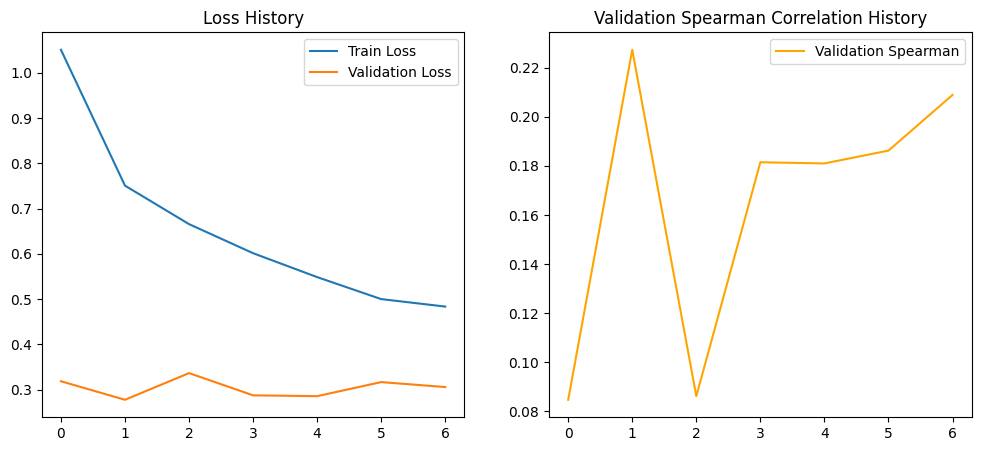

In [76]:
# A Trainer Class ---
class Trainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, scheduler, device, config):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.config = config
        
        self.history = {'train_loss': [], 'val_loss': [], 'val_spearman': []}
        self.best_spearman = -1.0
        self.epochs_no_improve = 0
        
    def _train_one_epoch(self):
        """Runs a single training epoch."""
        self.model.train()
        total_loss = 0.0
        
        for patches, targets in tqdm(self.train_loader, desc="Training"):
            patches = patches.to(self.device)
            targets = targets.to(self.device)
            
            # Forward pass
            outputs = self.model(patches)
            loss = self.criterion(outputs, targets)
            
            # Backward pass and optimization
            self.optimizer.zero_grad()
            loss.backward()
            
            # --- IMPROVEMENT: GRADIENT CLIPPING ---
            # Prevents exploding gradients for more stable training
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            self.optimizer.step()
            
            total_loss += loss.item()
            
        return total_loss / len(self.train_loader)

    def _validate_one_epoch(self):
        """Runs a single validation epoch."""
        self.model.eval()
        total_loss = 0.0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for patches, targets in tqdm(self.val_loader, desc="Validating"):
                patches = patches.to(self.device)
                targets = targets.to(self.device)
                
                outputs = self.model(patches)
                loss = self.criterion(outputs, targets)
                
                total_loss += loss.item()
                all_preds.extend(outputs.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())
                
        val_loss = total_loss / len(self.val_loader)
        val_spearman = calculate_average_spearman(all_preds, all_targets)
        return val_loss, val_spearman
        
    def fit(self):
        """The main training loop with early stopping."""
        start_time = time.time()
        
        for epoch in range(self.config['EPOCHS']):
            print(f"\n--- Epoch {epoch + 1}/{self.config['EPOCHS']} ---")
            
            train_loss = self._train_one_epoch()
            val_loss, val_spearman = self._validate_one_epoch()
            
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['val_spearman'].append(val_spearman)
            
            print(f"Epoch Summary: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Spearman: {val_spearman:.4f}")
            
            # Learning rate scheduler step
            self.scheduler.step(val_spearman)
            
            # --- IMPROVEMENT: EARLY STOPPING ---
            if val_spearman > self.best_spearman:
                print(f"Validation Spearman improved from {self.best_spearman:.4f} to {val_spearman:.4f}. Saving model...")
                self.best_spearman = val_spearman
                torch.save(self.model.state_dict(), self.config['MODEL_SAVE_PATH'])
                self.epochs_no_improve = 0
            else:
                self.epochs_no_improve += 1
                print(f"No improvement in validation Spearman for {self.epochs_no_improve} epoch(s).")
                
            if self.epochs_no_improve >= self.config['PATIENCE']:
                print(f"\nEarly stopping triggered after {self.config['PATIENCE']} epochs without improvement.")
                break
                
        end_time = time.time()
        print(f"\nTraining finished in {(end_time - start_time) / 60:.2f} minutes.")
        print(f"Best validation Spearman score: {self.best_spearman:.4f}")
        
        return self.history

# --- Main Execution Block ---
if __name__ == '__main__':
    # (Assuming all data loading cells have been run and train_loader/val_loader exist)
    
    # 1. Define Model, Loss, Optimizer, etc.
    model = get_model(num_classes=N_CELL_TYPES, dropout_p=0.5).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2, verbose=True)
    
    # 2. Bundle config into a dictionary
    config = {
        "EPOCHS": EPOCHS,
        "PATIENCE": PATIENCE,
        "MODEL_SAVE_PATH": MODEL_SAVE_PATH
    }

    # 3. Instantiate and run the trainer
    trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, scheduler, device, config)
    history = trainer.fit()

    # 4. Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss History')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['val_spearman'], label='Validation Spearman', color='orange')
    plt.title('Validation Spearman Correlation History')
    plt.legend()
    plt.show()

# Generating Test Set Predictions

In [79]:
import torch
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

# --- Configuration ---
# Ensure these variables are consistent with your training setup
MODEL_SAVE_PATH = "best_model.pth"
SUBMISSION_PATH = "submission.csv"
H5_FILE_PATH = "/kaggle/input/el-hackathon-2025/elucidata_ai_challenge_data.h5"
PATCH_SIZE = 256
BATCH_SIZE = 64 # You can often use a larger batch size for inference
NUM_WORKERS = 2
N_CELL_TYPES = 35 # Must match the model's output
test_ids = ['S_7'] # The slide IDs for the test set

# Use the same device as training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} for inference.")


# --- 1. Load the Trained Model ---
print("\n--- Loading best model weights ---")
# First, instantiate the model architecture (must be identical to the one you trained)
model = get_model(num_classes=N_CELL_TYPES, pretrained=False) # pretrained=False is fine, we are loading our own weights

# Load the saved state dictionary
model.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Move the model to the appropriate device and set to evaluation mode
model.to(device)
model.eval()
print("Model loaded successfully.")


# --- 2. Create the Test DataLoader ---
# Use the same DataFactory and Dataset classes as before
# The DataFactory should already be instantiated as 'data_factory' from training cells
print("\n--- Preparing test data ---")
test_df = data_factory.get_test_data(test_ids)

# We need the 'spot_id' for the submission file. The test DataFrame from the HDF5 file
# might have different column names. Let's assume the spot identifier column is the first one
# if it's not 'x' or 'y'. A more robust way is to check the dtype names.
with h5py.File(H5_FILE_PATH, "r") as f:
    # Let's get the exact names from the test set file
    test_col_names = [name.decode('utf-8') if isinstance(name, bytes) else name for name in f[f'spots/Test/{test_ids[0]}'].dtype.names]

# Let's assume the submission ID is the 'Test set' column, or another unique identifier.
# For this competition, let's create a unique ID from slide and spot index.
if 'spot_id' not in test_df.columns:
    test_df['spot_id'] = test_df.index.astype(str) # Create a default spot ID if not present

test_dataset = HESpotDataset(
    h5_path=H5_FILE_PATH,
    spots_df=test_df,
    patch_size=PATCH_SIZE,
    target_cols=[], # No target columns for test set
    transforms=get_transforms('test', PATCH_SIZE), # Use 'val' or 'test' mode transforms
    mode='test'
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, # Never shuffle the test set!
    num_workers=NUM_WORKERS
)
print(f"Test data loader created with {len(test_dataset)} spots.")

# --- 3. Prediction Loop ---
print("\n--- Generating predictions on the test set ---")
all_preds = []

with torch.no_grad(): # Disable gradient calculations for speed and memory efficiency
    for patches, _ in tqdm(test_loader, desc="Predicting"):
        patches = patches.to(device)
        
        # Get model outputs
        outputs = model(patches)
        
        # Move predictions to CPU and append to our list
        all_preds.extend(outputs.cpu().numpy())

# Convert list of predictions to a NumPy array
predictions_np = np.array(all_preds)
print(f"Predictions generated. Shape: {predictions_np.shape}")

Using device: cuda for inference.

--- Loading best model weights ---
Model loaded successfully.

--- Preparing test data ---
Test data loader created with 2088 spots.

--- Generating predictions on the test set ---


/tmp/ipykernel_31/2249281874.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_SAVE_PATH))


Predicting:   0%|          | 0/33 [00:00<?, ?it/s]

Predictions generated. Shape: (2088, 35)


# Creating the Submission File

In [89]:
import pandas as pd
import numpy as np

# --- Configuration ---
SUBMISSION_PATH = "submission.csv"
SAMPLE_SUBMISSION_PATH = "/kaggle/working/submission.csv" 
N_CELL_TYPES = 35

# --- Assume these variables exist from your prediction loop ---
# predictions_np: A NumPy array of shape (num_test_spots, 35) containing your model's predictions.
# test_loader: The DataLoader used for the test set, with shuffle=False.

# Let's create dummy variables for demonstration if they don't exist yet
if 'predictions_np' not in locals():
    print("Creating dummy `predictions_np` for demonstration.")
    # This assumes a test_df DataFrame is available to get the number of spots
    if 'test_df' in locals():
        num_test_spots = len(test_df)
    else: # Fallback if test_df doesn't exist
        print("Warning: `test_df` not found, creating predictions for 1000 spots as an example.")
        num_test_spots = 1000
    predictions_np = np.random.rand(num_test_spots, N_CELL_TYPES)

# --- 4. Create the Submission File (The Final, Correct Way) ---
print("\n--- Creating submission.csv file using sample_submission.csv as a template ---")

try:
    # Step 4.1: Load the sample submission file
    sample_df = pd.read_csv(SAMPLE_SUBMISSION_PATH)
    print("Sample submission file loaded successfully.")
    print("Columns found in sample submission:", sample_df.columns.tolist())
    
    # Step 4.2: Verify that the number of predictions matches the number of rows
    if len(sample_df) != len(predictions_np):
        raise ValueError(f"CRITICAL ERROR: Mismatch in prediction rows. "
                         f"Model predicted for {len(predictions_np)} spots, but sample submission has {len(sample_df)} rows.")

    # Step 4.3: Get the names of the target columns from the sample file
    # --- THIS IS THE CORRECTED LINE ---
    # We now look for the column named 'ID' (all caps) to exclude it.
    target_cols = [col for col in sample_df.columns if col != 'ID']
    
    if len(target_cols) == 0:
        raise KeyError("Could not find any target columns in the sample submission file. "
                       "Check that the ID column is actually named 'ID'.")
        
    if len(target_cols) != N_CELL_TYPES:
         raise ValueError(f"CRITICAL ERROR: Mismatch in number of target columns. "
                         f"Model outputs {N_CELL_TYPES}, but sample file expects {len(target_cols)}.")

    print(f"Found ID column 'ID' and {len(target_cols)} target columns.")

    # Step 4.4: Assign your predictions to the target columns
    # The order is preserved because shuffle=False was used in the test DataLoader.
    sample_df[target_cols] = predictions_np
    
    # The 'ID' column from the sample_df is preserved perfectly.
    submission_df = sample_df

    # Step 4.5: Save the final DataFrame to a .csv file
    submission_df.to_csv(SUBMISSION_PATH, index=False)

    print(f"\nSubmission file created successfully at: {SUBMISSION_PATH}")
    print("Final submission file head:")
    print(submission_df.head())

except FileNotFoundError:
    print(f"ERROR: The sample submission file was not found at '{SAMPLE_SUBMISSION_PATH}'. "
          "Please check the file path.")
except KeyError:
    print("ERROR: The column 'ID' was not found in the sample submission file. "
          "Please double-check the exact column name for the spot identifiers in sample_submission.csv.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


--- Creating submission.csv file using sample_submission.csv as a template ---
Sample submission file loaded successfully.
Columns found in sample submission: ['ID', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C31', 'C32', 'C33', 'C34', 'C35']
Found ID column 'ID' and 35 target columns.

Submission file created successfully at: submission.csv
Final submission file head:
   ID        C1        C2        C3        C4        C5        C6        C7  \
0   0  0.570850  0.212751  0.371165  0.188890  0.530625  0.090755  0.052882   
1   1  0.466736  0.132308  0.360251  0.204791  0.993428  0.029110  0.090087   
2   2  0.839582  0.072354  0.515620  0.338352  2.817312  0.026442  0.088972   
3   3  1.074883  0.001687  0.673742  0.432468  0.575237  0.067159  0.052738   
4   4  0.690716  0.083037  0.460665  0.323073  0.508817  0.034770  0.0952